# Clustering Animal Data using PYSOM Library

## Import Modules

In [1]:
!pip install pandas sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# PYSOM LIBRARY MODULES:
import pysom
from pysom.node import Node
from pysom.graph import Graph
from pysom.nodes.bmu import BMU
from pysom.nodes.dist import Dist
from pysom.nodes.concat import Concat
from pysom.nodes.calibrate import Calibrate
from pysom.nodes.som import SOM, nhood_mexican, nhood_bubble, dist_manhattan, dist_cosine

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


## Load Animal Data

In [2]:
animal = ['Dove', 'Chicken', 'Duck', 'Goose', 'Owl', 'Hawk', 'Eagle', 'Fox', 'Dog', 'Wolf', 'Cat', 'Tiger', 'Lion', 'Horse', 'Zebra', 'Cow']
features = [
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],    # Dove
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],    # Chicken
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],    # Duck
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],    # Goose
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],    # Owl
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],    # Hawk
    [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],    # Eagle
    [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],    # Fox
    [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],    # Dog
    [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],    # Wolf
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],    # Cat
    [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],    # Tiger
    [0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],    # Lion
    [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],    # Horse
    [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],    # Zebra
    [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]     # Cow
]

feats = pd.DataFrame(features)
feats.columns = ['Small', 'Medium', 'Big', '2-legs', '4-legs', 'Hair', 'Hooves', 'Mane', 'Feathers', 'Hunt', 'Run', 'Fly', 'Swim']

## Helper Plot Function

In [3]:
def plot_features(size, out):
    for bmu, labels in out.items():
        labels = list(labels)
        print(labels)

        for i in range(len(labels)):
            plt.text(bmu[0] + 0.1, bmu[1] + (i + 1) / len(labels) - 0.35, labels[i], fontsize=10)

    plt.xticks(np.arange(size + 1))
    plt.yticks(np.arange(size + 1))
    plt.grid()
    plt.show()

# Train Simple SOM on Animal Data

['Dove', 'Chicken', 'Duck', 'Goose']
['Owl', 'Hawk']
['Eagle']
['Fox', 'Dog', 'Wolf']
['Cat']
['Tiger']
['Lion']
['Horse', 'Zebra']
['Cow']


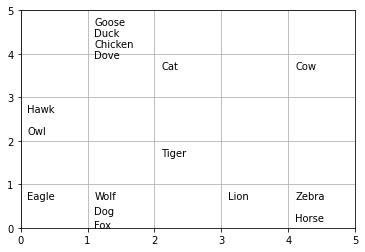

In [7]:
size = 5
g = Graph()

som = g.create(SOM, props={'size': size, 'dim': 13, "nhood": nhood_mexican, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})
g.connect(g.start, som, 1)

cal = g.create(Calibrate, props={"labels": animal})


g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

data = scale(feats.values)

g.set_input(data)
out = g.get_output()
plot_features(size, out)

# Train Deep SOM on Animal Data (1) Logical Groupings

                  *->som(size)->bmu(size)->*
                 /                          \\
                /--->som(legs)->bmu(legs)----\\
    animal -> dist                          concat -> som -> calibrate(labels)
                \\-->som(char)->bmu(char)----/
                 \\                         /
                  *->som(move)->bmu(move)->*

['Dove', 'Chicken', 'Duck', 'Goose']
['Owl', 'Hawk']
['Eagle']
['Fox']
['Dog']
['Wolf', 'Tiger']
['Cat']
['Lion']
['Horse', 'Zebra']
['Cow']


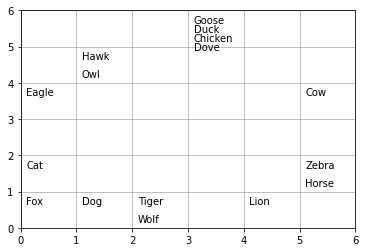

In [9]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})
g.connect(g.start, dist, 1)

som_size = g.create(SOM, props={"size": 16, "dim": 3, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(SOM, props={"size": 16, "dim": 2, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som_char = g.create(SOM, props={"size": 16, "dim": 4, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som_move = g.create(SOM, props={"size": 16, "dim": 4, "sigma": 15, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_move, 4)

bmu_size = g.create(BMU, props={"output": "w"})
bmu_legs = g.create(BMU, props={"output": "w"})
bmu_char = g.create(BMU, props={"output": "w"})
bmu_move = g.create(BMU, props={"output": "w"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_move, concat, 1)

size = 6

som = g.create(SOM, props={'size': size, 'dim': 13, "nhood": nhood_mexican, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})

g.connect(concat, som, 1)

cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

data = scale(feats.values)
g.set_input(data)

out = g.get_output()

plot_features(size, out)

# Train Deep SOM on Animal Data (2) Multiply Hunt

                  *--->som(size)->bmu(size)--->*
                 /                              \\
                /----->som(legs)->bmu(legs)------\\
    animal -> dist                          concat -> som -> calibrate(labels)
                \\---->som(char)->bmu(char)------/
                 \\                             /
                  \\-->som(hunt)->bmu(hunt)----/
                   \\                         /
                    *->som(move)->bmu(move)->*
                     (move doubles up on hunt)

['Dove', 'Chicken', 'Duck', 'Goose']
['Owl', 'Hawk']
['Eagle']
['Fox', 'Cat']
['Dog']
['Wolf']
['Tiger']
['Lion']
['Horse', 'Zebra']
['Cow']


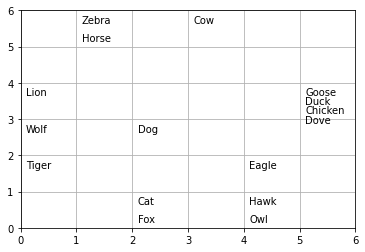

In [10]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})
g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={"size": 16, "dim": 3, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={"size": 16, "dim": 2, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={"size": 16, "dim": 4, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={"size": 16, "dim": 1, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={"size": 16, "dim": 4, "sigma": 15, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "w"})
bmu_legs = g.create(BMU, props={"output": "w"})
bmu_char = g.create(BMU, props={"output": "w"})
bmu_hunt = g.create(BMU, props={"output": "w"})
bmu_move = g.create(BMU, props={"output": "w"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 6

som = g.create(SOM, props={'size': size, 'dim': 14,
               "nhood": nhood_mexican, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})

g.connect(concat, som, 1)

cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

data = scale(feats.values)
g.set_input(data)

out = g.get_output()

plot_features(size, out)

# Train Deep SOM on Animal Data (3) Like with Like


                  *---> (small, 2leg, feather,fly,swim)--->*
                 /                                          \\
                /                                            \\
    animal -> dist --------> (med, 4leg, hair, run)-------> concat -> som -> calibrate(labels)
                \\                                             /
                 \\                                           /
                  *---> (large, 4leg, hooves, mane, hunt)--->*
    

['Dove', 'Chicken', 'Duck', 'Goose']
['Owl', 'Hawk']
['Eagle']
['Fox']
['Dog']
['Wolf', 'Tiger']
['Cat']
['Lion', 'Horse', 'Zebra', 'Cow']


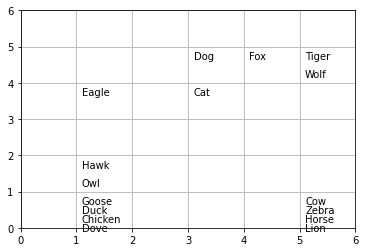

In [11]:
g = Graph()

sel = [(1, [0, 3, 8, 11, 12]), (1, [1, 4, 5, 10]), (1, [2, 4, 6, 7, 9])]

dist = g.create(Dist, props={"selections": sel})
g.connect(g.start, dist, 1)

som1 = g.create(
    SOM, props={"size": 16, "dim": 5, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som2 = g.create(
    SOM, props={"size": 16, "dim": 4, "sigma": 15, "lr": 0.8, "n_iters": 10000})
som3 = g.create(
    SOM, props={"size": 16, "dim": 5, "sigma": 15, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som1, 1)
g.connect(dist, som2, 2)
g.connect(dist, som3, 3)

bmu1 = g.create(BMU, props={"output": "w"})
bmu2 = g.create(BMU, props={"output": "w"})
bmu3 = g.create(BMU, props={"output": "w"})

g.connect(som1, bmu1, 0)
g.connect(som2, bmu2, 0)
g.connect(som3, bmu3, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu1, concat, 1)
g.connect(bmu2, concat, 1)
g.connect(bmu3, concat, 1)

size = 6

som = g.create(SOM, props={'size': size, 'dim': 14,
               "nhood": nhood_mexican, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})

g.connect(concat, som, 1)

cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

data = scale(feats.values)
g.set_input(data)

out = g.get_output()

plot_features(size, out)

# Train Deep SOM on Animal Data (4) Pushing the Limits 1

                                                :---------------(2leg,4leg,run)
                  *----> (small, 2leg)*-------------->*         .. pass along ..
                 /       feather,fly   \\       :     :                     |
                |           swim         *--> concat --> (fly, swim)------------------*
                /                       /             :           2leg, 4leg, run     |
    animal -> dist ----> (med, 4leg)------------->(concat)---> (small, med, large)--> *-> calibrate
                \\        hair, run     \\            : (feather, hair, hooves, mane) |
                ||                       *--> concat --> (hunt)-----------------------*
                 \\                     /             :
                  *---> (large, 4leg)->*------------->*
                    hooves, mane, hunt
 

['Dove', 'Owl', 'Hawk', 'Eagle']
['Chicken', 'Duck', 'Goose']
['Fox']
['Dog', 'Wolf']
['Cat']
['Tiger', 'Lion', 'Horse', 'Zebra']
['Cow']


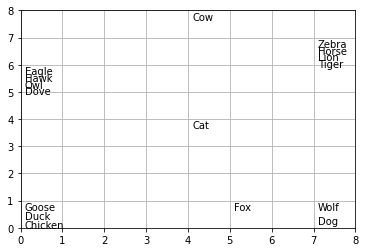

defaultdict(list,
            {(0, 5): Counter({'Dove': 1, 'Owl': 1, 'Hawk': 1, 'Eagle': 1}),
             (0, 0): Counter({'Chicken': 1, 'Duck': 1, 'Goose': 1}),
             (5, 0): Counter({'Fox': 1}),
             (7, 0): Counter({'Dog': 1, 'Wolf': 1}),
             (4, 3): Counter({'Cat': 1}),
             (7, 6): Counter({'Tiger': 1, 'Lion': 1, 'Horse': 1, 'Zebra': 1}),
             (4, 7): Counter({'Cow': 1})})

In [14]:
g = Graph()

sel = [(1, [0, 3, 8, 11, 12]), (1, [1, 4, 5, 10]), (1, [2, 4, 6, 7, 9])]

dist = g.create(Dist, props={"selections": sel})
g.connect(g.start, dist, 1)

som11 = g.create(SOM, props={"size": 16, "dim": 5, "sigma": 3, "lr": 0.8, "hexagonal": True, "n_iters": 10})
som12 = g.create(SOM, props={"size": 16, "dim": 4, "sigma": 1, "lr": 0.8, "dist": dist_manhattan, "n_iters": 100})
som13 = g.create(SOM, props={"size": 16, "dim": 5, "sigma": 2, "dist": dist_cosine, "lr": 0.8, "n_iters": 1000})

g.connect(dist, som11, 1)
g.connect(dist, som12, 2)
g.connect(dist, som13, 3)

bmu11 = g.create(BMU, props={"output": "w"})
bmu12 = g.create(BMU, props={"output": "w"})
bmu13 = g.create(BMU, props={"output": "w"})

g.connect(som11, bmu11, 0)
g.connect(som12, bmu12, 0)
g.connect(som13, bmu13, 0)

con11 = g.create(Concat, props={"axis": 1})
con12 = g.create(Concat, props={"axis": 1})

g.connect(bmu11, con11, 1)
g.connect(bmu12, con11, 1)
g.connect(bmu12, con12, 1)
g.connect(bmu13, con12, 1)

dist_flyswim_24run = g.create(Dist, props={"selections": [(1, [3, 4]), (1, [1, 6, 8])]})

g.connect(con11, dist_flyswim_24run, 1)
som_flyswim = g.create(SOM, props={"size": 10, "dist": dist_cosine, "hexagonal": True, "dim": 2, "sigma": 2, "lr": 0.7, "n_iters": 1000})

g.connect(dist_flyswim_24run, som_flyswim, 1)
bmu_flyswim = g.create(BMU, props={"output": "w"})
g.connect(som_flyswim, bmu_flyswim, 0)

node_24run = g.create(Node)
g.connect(dist_flyswim_24run, node_24run, 2)    # skips layer

dist_hunt = g.create(Dist, props={"selections": [(1, [4])]})
g.connect(con12, dist_hunt, 1)
som_hunt = g.create(SOM, props={"size": 14, "dim": 1, "sigma": 7, "lr": 1, "hexagonal": True, "n_iters": 1000})
g.connect(dist_hunt, som_hunt, 1)
bmu_hunt = g.create(BMU, props={"output": "w"})
g.connect(som_hunt, bmu_hunt, 0)

con2 = g.create(Concat, props={"axis": 1})

g.connect(bmu11, con2, 1)
g.connect(bmu12, con2, 1)
g.connect(bmu13, con2, 1)

dist_sml_feats = g.create(Dist, props={"selections": [(1, [0, 5, 9, 2, 7, 8, 9])]})
g.connect(con2, dist_sml_feats, 1)
som_sml_feats = g.create(SOM, props={"size": 16, "dim": 7, "sigma": 3, "lr": 1, "hexagonal": True, "n_iters": 10000})
g.connect(dist_sml_feats, som_sml_feats, 1)
bmu_sml_feats = g.create(BMU, props={"output": "w"})
g.connect(som_sml_feats, bmu_sml_feats, 0)

con3 = g.create(Concat, props={"axis": 1})

g.connect(bmu_flyswim, con3, 1)
g.connect(bmu_hunt, con3, 1)
g.connect(bmu_sml_feats, con3, 1)
g.connect(node_24run, con3, 1)

size = 8
som = g.create(SOM, props={'size': size, 'dim': 13, "dist": dist_manhattan, "hexagonal": True, 'sigma': 2, 'lr': 0.6, 'n_iters': 1000})
g.connect(con3, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)
data = scale(feats.values)
g.set_input(data)
out = g.get_output()

plot_features(size, out)